<a href="https://colab.research.google.com/github/UW-CTRL/stljax/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If running in colab, in a cell, run the following command:

`!pip install --upgrade git+https://github.com/UW-CTRL/stljax.git`

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from stljax.formula import *
from stljax.viz import *

import functools

## NOTE
If using Expressions to define formulas, `stljax` expects input signals to be of size `[time_dim]`.
If using Predicates to define formulas, `stljax` expects input signals to be of size `[time_dim, state_dim]` where `state_dim` is the expected input size of your predicate function.

Note: With the `mask` version, we do not need to worry about reversing the signal.

In [4]:
#  some helper functions

@jax.jit
def dynamics_discrete_step(state, control, dt=0.1):
    '''Single integrator 2d dynamics'''
    return state + control * dt

@jax.jit
def simulate_dynamics(controls, state0, dt):
    T = controls.shape[0]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], controls[t,:], dt))
    return jnp.concatenate(_states, 0)

@jax.jit
def compute_distance_to_origin(states):
    return jnp.linalg.norm(states[...,:2], axis=-1, keepdims=True)

(np.float64(-2.8336225271224977),
 np.float64(0.658743929862976),
 np.float64(-2.5266865134239196),
 np.float64(0.6441279292106629))

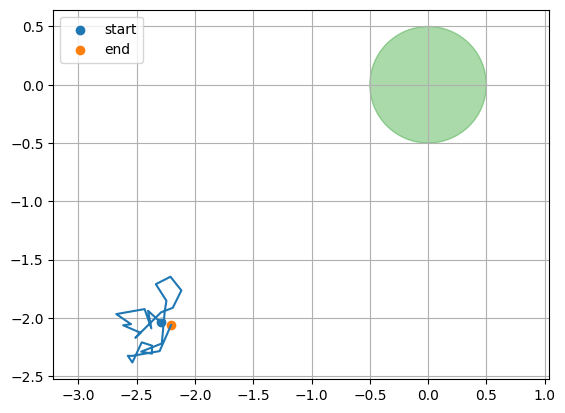

In [5]:
# In this example, using a control sequence to generate a state trajectory
T = 25  # time horizon
dt = 0.1
time_dim = 1 # axis corresponding to time dimension
np.random.seed(123)
controls = jnp.array(np.random.randn(T,2))   # generate control sequence
state0 = jnp.array(np.random.randn(1,2)) - 1.0   # initial state
states = simulate_dynamics(controls, state0, dt)   # simulate state trajectory

# plotting the trajectory (should look noisy/random)
fig, ax = plt.subplots()
ax.plot(*states.T)
ax.scatter(states[0,:1], states[0,1:], label="start")
ax.scatter(states[-1,:1], states[-1,1:], label="end")
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
ax.add_patch(circle1)

plt.xlim([-5,1])
plt.ylim([-4,1])
plt.legend()
plt.grid()
plt.axis("equal")


## Using Expressions

In [6]:
# first define Expression (with None value)
# NOTE: Expressions are used for setting up predicates.
#       The values associated with an Expression is more for convenience.
#       You can use a jnp.array directly when evaluating a formula, rather than using an Expression with values populated.
distance_to_origin_exp = Expression("magnitude", value=None)

# formula Eventually distance to origin is less than 0.5
formula_exp = Eventually(distance_to_origin_exp < 0.5)


# this will throw error since the Expression value is None.
# (commented out for convenience in running the notebook)
# formula(distance_to_origin_exp)

# setting value for
states_norm = compute_distance_to_origin(states)   # compute distance to origin, size [1, 26, 1]

distance_to_origin_exp.set_value(states_norm)   # set value for Expression


# compute robustness trace and value
# inputs are Expression objects
# since reverse=False, stljax will automatically time reverse the input signal, and warn user about it.

# robustness trace
print("Robustness trace: ", formula_exp(distance_to_origin_exp).squeeze())

# robustness value
print("Robustness value: ", formula_exp.robustness(distance_to_origin_exp).squeeze())


Robustness trace:  [-2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.256407  -2.3951554 -2.4112952 -2.477519  -2.5186005 -2.5186005
 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005
 -2.5186005 -2.5186005]
Robustness value:  -2.2557175


In [7]:
# we can jit the robustness function and its gradient.
f = jax.jit(formula_exp.robustness)
g = jax.jit(jax.grad(f))

# measure the time it takes to compute a forward and backward pass
# very fast!
%timeit f(distance_to_origin_exp.value)
%timeit g(distance_to_origin_exp.value)

5.6 μs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.6 μs ± 102 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
# we can batch the computation
bs = 4
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX
signals = jax.random.uniform(key, shape=(bs, T)) 

jax.vmap(f)(signals), jax.vmap(g)(signals)

(Array([0.4814521 , 0.49946868, 0.45444584, 0.44981503], dtype=float32),
 Array([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]],      dtype=float32))

In [9]:
# We can apply different max/min approximations
bs = 4
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX
signals = jax.random.uniform(key, shape=(bs, T)) # shape [bs, T]

# Default: approx_method="true" -- taking gradient using the true min/max function
jax.vmap(jax.grad(formula_exp.robustness))(signals)

# taking gradient using a min/max approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well

# logsumexp approximation
foo = functools.partial(formula_exp.robustness, approx_method="logsumexp", temperature=1.) 
jax.vmap(jax.grad(foo))(signals)

# # softmax approximation
foo = functools.partial(formula_exp.robustness, approx_method="softmax", temperature=1.) 
jax.vmap(jax.grad(foo))(signals)


Array([[-0.02582416, -0.0514056 , -0.01276034, -0.04622918, -0.03386938,
        -0.06998569, -0.05163663, -0.06342276, -0.03815436, -0.07147011,
        -0.01940775, -0.05362437, -0.04669334, -0.03519493, -0.0166717 ,
        -0.02356261, -0.02027061, -0.00810847, -0.04404066, -0.06902726,
        -0.04640958, -0.04664499, -0.03303727, -0.03973469, -0.03281348],
       [-0.06602133, -0.0323073 , -0.01701606, -0.02895677, -0.01675591,
        -0.03107198, -0.02742128, -0.04578061, -0.01740972, -0.07078583,
        -0.04380497, -0.06857068, -0.01038632, -0.00757802, -0.04489319,
        -0.0553256 , -0.04845608, -0.0576579 , -0.01687001, -0.04463371,
        -0.02515552, -0.07106859, -0.06927916, -0.00785302, -0.07494054],
       [-0.0698043 , -0.01172489, -0.03137346, -0.07852152, -0.03564867,
        -0.06827941, -0.01655721, -0.03844461, -0.01342334, -0.03133292,
        -0.0134404 , -0.02768762, -0.03235616, -0.03376853, -0.02919685,
        -0.06583954, -0.05004779, -0.02036106, -0

## Using Predicates

Alternatively, we can define the predicate function of an STL formula where predicate function is μ: Rⁿ → R and the input is an n-dimensional signal.

In [7]:
distance_to_origin_pred = Predicate("magnitude", predicate_function=compute_distance_to_origin)
formula_pred = Eventually(distance_to_origin_pred < 0.5)

formula_pred(states).squeeze()

# compute robustness trace and value
# inputs are jnp.arrays
# robustness trace
print("Robustness trace: ", formula_pred(states).squeeze() )

# robustness value
print("Robustness value: ", formula_pred.robustness(states).squeeze())

Robustness trace:  [-2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.256407  -2.3951554 -2.4112952 -2.477519  -2.5186005 -2.5186005
 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005
 -2.5186005 -2.5186005]
Robustness value:  -2.2557175


In [11]:
# we can jit the robustness function and its gradient.
f = jax.jit(formula_pred.robustness)
g = jax.jit(jax.grad(f))

# measure the time it takes to compute a forward and backward pass
# very fast!
%timeit f(states)
%timeit g(states)

6.36 μs ± 387 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
9.35 μs ± 189 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
# we can batch the computation
bs = 4
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX
signals = jax.random.uniform(key, shape=(bs, T, 2)) 

jax.vmap(f)(signals), jax.vmap(g)(signals)

(Array([0.4808055 , 0.16095048, 0.35008496, 0.2274302 ], dtype=float32),
 Array([[[-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.        , -0.        ],
         [-0.5642942 , -0.82557374],
         [-0.        , -0.        ]],
 

In [13]:
# We can apply different max/min approximations
bs = 4
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX
signals = jax.random.uniform(key, shape=(bs, T, 2)) # shape [bs, T, state_dim]

# Default: approx_method="true" -- taking gradient using the true min/max function
jax.vmap(jax.grad(formula_pred.robustness))(signals)

# taking gradient using a min/max approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well

# logsumexp approximation
foo = functools.partial(formula_pred.robustness, approx_method="logsumexp", temperature=1.) 
jax.vmap(jax.grad(foo))(signals)

# # softmax approximation
foo = functools.partial(formula_pred.robustness, approx_method="softmax", temperature=1.) 
jax.vmap(jax.grad(foo))(signals)


Array([[[-0.02352086, -0.02653968],
        [-0.01435679, -0.00693523],
        [-0.03308038, -0.01781628],
        [-0.01722912, -0.02483274],
        [-0.04262575, -0.06899171],
        [-0.0105945 , -0.01726518],
        [-0.02208826, -0.01126937],
        [-0.02735491, -0.02297586],
        [-0.01796402, -0.00646728],
        [-0.02368197, -0.00658443],
        [-0.01846283, -0.01260185],
        [-0.05555077, -0.02745588],
        [-0.00655061, -0.0230543 ],
        [-0.07459132, -0.04124878],
        [-0.01915025, -0.02961909],
        [-0.01502226, -0.00939996],
        [-0.01998683, -0.01625802],
        [-0.00708358, -0.00567479],
        [-0.01812643, -0.01658712],
        [-0.01440577, -0.00744342],
        [-0.05441307, -0.07690613],
        [-0.00256752, -0.01885604],
        [-0.08005733, -0.02827522],
        [-0.07011323, -0.10257705],
        [-0.02251863, -0.02088918]],

       [[-0.0288817 , -0.04554031],
        [-0.02986922, -0.03051575],
        [-0.06544525, -0.0

## Gradient descent to optimize control inputs

Now, we can perform gradient descent on the control inputs to make progress towards the formula being true.

### Using `Expression`

In [8]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
time_dim = 1
umax = 1.0  # max control limit

controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.ones(2).reshape([1,2]) * 3.
obstacle_center = jnp.ones([1,2]) * 2.


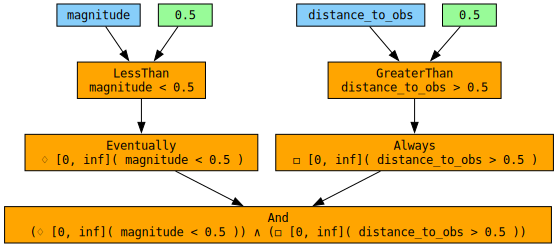

In [9]:
# defining formula
distance_to_origin = Expression("magnitude", None)
distance_to_obstacle = Expression("distance_to_obs", None)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)
formula = reach & avoid

make_stl_graph(formula)


In [10]:
@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(controls, state0, umax, dt, coeffs=[1., 0.1, 5.], approx_method="true", temperature=None):
    # generate trajectory from control sequence 
    traj = simulate_dynamics(controls, state0, dt)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj, axis=-1)
    distance_to_obstacle_signal = jnp.linalg.norm(traj - obstacle_center, axis=-1)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    loss_robustness = jax.nn.relu(-formula.robustness(input_signal, approx_method=approx_method, temperature=temperature))
    loss_control_smoothness = (jnp.diff(controls, axis=1)**2).sum(-1).mean()  # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits

# @jax.jit
def true_robustness(controls, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    # user has to manually reverse it since we are inputing jnp.array to compute robustness, instead of an Expression
    traj = simulate_dynamics(controls, state0, dt)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj, axis=-1)
    distance_to_obstacle_signal = jnp.linalg.norm(traj - obstacle_center, axis=-1)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    return formula.robustness(input_signal)

def temperature_schedule(i, i_max, start_temp, end_temp, scale=5):
    i_ = i
    center = i_max / 2
    return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
loss(controls, state0, umax, dt), loss(controls, state0, umax, dt, approx_method="softmax", temperature=5)

(Array(6.845453, dtype=float32), Array(6.995544, dtype=float32))

In [11]:
controls = jnp.array(np.random.randn(T,2))

states_ = [simulate_dynamics(controls, state0, dt)]
lr = 0.5 # learning rate
approx_method = "true"
n_steps = 1000   # number of gradient steps
n_steps_extra = 10
coeffs = [1., 0.1, 5.]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(jax.grad(loss, 0), static_argnames="approx_method")
# temperature schedule parameters
start_temp = 50
end_temp = 500
scale = 5


In [12]:
temperatures = temperature_schedule(jnp.arange(n_steps), n_steps, start_temp, end_temp, scale)
for i in range(n_steps):
    temperature = temperature_schedule(i, n_steps, start_temp, end_temp, scale)
    g = grad_jit(controls, state0, umax, dt, coeffs, approx_method, temperatures[i])   # take gradient
    controls -= g * lr
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f"%(i, true_robustness(controls, state0, dt), loss(controls, state0, umax, dt, coeffs=[0., 1., 0.]), loss(controls, state0, umax, dt, coeffs=[0., 0., 1.])))


  0 -- true robustness: -3.68   smoothness: 1.81    control limits: 0.34
 50 -- true robustness: -0.04   smoothness: 0.36    control limits: 0.03
100 -- true robustness: 0.07   smoothness: 0.26    control limits: 0.00
150 -- true robustness: 0.05   smoothness: 0.20    control limits: 0.00
200 -- true robustness: 0.07   smoothness: 0.16    control limits: 0.00
250 -- true robustness: 0.06   smoothness: 0.13    control limits: 0.00
300 -- true robustness: 0.04   smoothness: 0.11    control limits: 0.00
350 -- true robustness: 0.04   smoothness: 0.09    control limits: 0.00
400 -- true robustness: 0.04   smoothness: 0.08    control limits: 0.00
450 -- true robustness: 0.03   smoothness: 0.07    control limits: 0.00
500 -- true robustness: 0.03   smoothness: 0.07    control limits: 0.00
550 -- true robustness: 0.03   smoothness: 0.06    control limits: 0.00
600 -- true robustness: 0.02   smoothness: 0.06    control limits: 0.00
650 -- true robustness: 0.03   smoothness: 0.06    control lim

Text(0, 0.5, 'Controls')

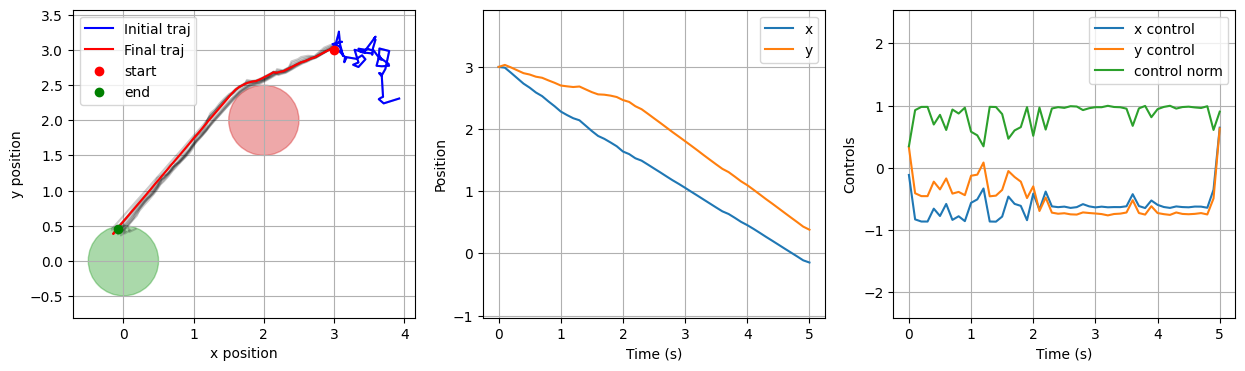

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

N = 100
[ax.plot(*s.T, color="k", alpha=0.2) for s in states_[::N]]
[ax.plot(*s.T, color="blue", label="Initial traj") for s in states_[:1]]
[ax.plot(*s.T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,:1], states_[-1][0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], zorder=10, label="end", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][:-1,:1], label="x")
ax.plot(ts, states_[-1][:-1,1:], label="y")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[:,:1], label="x control")
ax.plot(ts, controls[:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


### Using Predicates

In [14]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
time_dim = 1
umax = 1.0  # max control limit

controls = jnp.array(np.random.randn(T,2))
state0 = jnp.ones(2).reshape([1,2]) * 3.
obstacle_center = jnp.ones([1,2]) * 2.


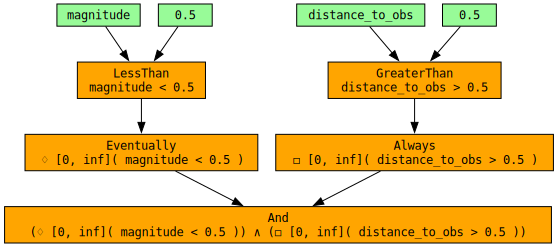

In [15]:
# defining formula

def compute_distance_to_point(states, point):
    return jnp.linalg.norm(states[...,:2] - point, axis=-1, keepdims=True)

def compute_distance_to_origin(states):
    return compute_distance_to_point(states, jnp.zeros(2))



distance_to_origin = Predicate("magnitude", compute_distance_to_origin)
distance_to_obstacle = Predicate("distance_to_obs", lambda x: compute_distance_to_point(x, obstacle_center))
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)
formula = reach & avoid

make_stl_graph(formula)


In [16]:
@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(controls, state0, umax, dt, coeffs=[1., 0.1, 5.], approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    loss_robustness = jax.nn.relu(-formula.robustness(traj,approx_method=approx_method, temperature=temperature))
    loss_control_smoothness = (jnp.diff(controls, axis=1)**2).sum(-1).mean()  # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits

@jax.jit
def true_robustness(controls, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    return formula.robustness(traj).mean()

def temperature_schedule(i, i_max, start_temp, end_temp, scale=5):
    i_ = i
    center = i_max / 2
    return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
loss(controls, state0, umax, dt), loss(controls, state0, umax, dt, approx_method="softmax", temperature=5)

(Array(6.3558393, dtype=float32), Array(6.573565, dtype=float32))

In [17]:
states_ = [simulate_dynamics(controls, state0, dt)]
lr = 0.5 # learning rate
approx_method = "logsumexp"
n_steps = 1000   # number of gradient steps
n_steps_extra = 10
coeffs = [1., 0.1, 5.]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(jax.grad(loss, 0), static_argnames="approx_method")
# temperature schedule parameters
start_temp = 50
end_temp = 500
scale = 5

In [18]:
temperatures = temperature_schedule(jnp.arange(n_steps), n_steps, start_temp, end_temp, scale)
for i in range(n_steps):
    g = grad_jit(controls, state0, umax, dt, coeffs, approx_method, temperatures[i])  # take gradient
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g * lr
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f"%(i, true_robustness(controls, state0, dt), loss(controls, state0, umax, dt, coeffs=[0., 1., 0.]), loss(controls, state0, umax, dt, coeffs=[0., 0., 1.])))


  0 -- true robustness: -3.23   smoothness: 2.11    control limits: 0.52
 50 -- true robustness: -0.95   smoothness: 0.36    control limits: 0.11
100 -- true robustness: -0.04   smoothness: 0.26    control limits: 0.04
150 -- true robustness: 0.02   smoothness: 0.20    control limits: 0.00
200 -- true robustness: 0.03   smoothness: 0.16    control limits: 0.00
250 -- true robustness: 0.02   smoothness: 0.13    control limits: 0.00
300 -- true robustness: 0.04   smoothness: 0.12    control limits: 0.00
350 -- true robustness: 0.02   smoothness: 0.10    control limits: 0.00
400 -- true robustness: 0.01   smoothness: 0.10    control limits: 0.00
450 -- true robustness: 0.02   smoothness: 0.09    control limits: 0.00
500 -- true robustness: 0.00   smoothness: 0.08    control limits: 0.00
550 -- true robustness: 0.04   smoothness: 0.09    control limits: 0.00
600 -- true robustness: 0.02   smoothness: 0.08    control limits: 0.00
650 -- true robustness: 0.01   smoothness: 0.09    control li

Text(0, 0.5, 'Controls')

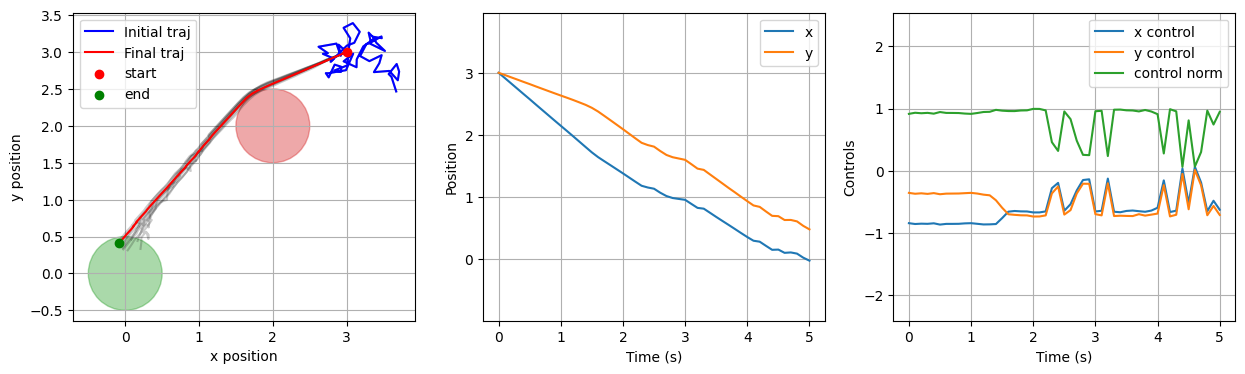

In [19]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

N = 100
[ax.plot(*s.T, color="k", alpha=0.2) for s in states_[::N]]
[ax.plot(*s.T, color="blue", label="Initial traj") for s in states_[:1]]
[ax.plot(*s.T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,:1], states_[-1][0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], zorder=10, label="end", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][:-1,:1], label="x")
ax.plot(ts, states_[-1][:-1,1:], label="y")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[:,:1], label="x control")
ax.plot(ts, controls[:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


## Parametric STL
We can take gradients with respect to the RHS constant in the <, >, == STL formulas

As a simple example, we using the final trajectory in the example above to find the value of `c` such that the formula `Always(distance_to_obstacle > c)` is as tight as possible.

In [20]:
def parametric_stl_robustness(c, signal):
    return Always(distance_to_obstacle > c).robustness(signal)**2

traj = states_[-1]
grad_jit = jax.jit(jax.grad(lambda c: parametric_stl_robustness(c, traj)))

c = 2.
cs = [c]
lr = 0.05
for i in range(100):
    g = grad_jit(c)
    c -= g * lr
    cs.append(c)
    if (i % 10) == 0:
        print("%3i -- true robustness: %.4f  "%(i, parametric_stl_robustness(c, traj)))


  0 -- true robustness: 1.7771  
 10 -- true robustness: 0.2160  
 20 -- true robustness: 0.0263  
 30 -- true robustness: 0.0032  
 40 -- true robustness: 0.0004  
 50 -- true robustness: 0.0000  
 60 -- true robustness: 0.0000  
 70 -- true robustness: 0.0000  
 80 -- true robustness: 0.0000  
 90 -- true robustness: 0.0000  


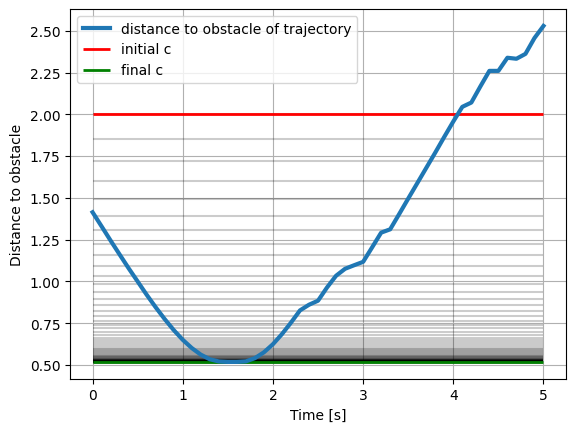

In [21]:

plt.plot(ts, jnp.linalg.norm(traj - obstacle_center, axis=-1, keepdims=True).squeeze()[:-1], linewidth=3, label="distance to obstacle of trajectory", zorder=5)
plt.hlines(cs[0], ts[0], ts[-1], linewidth=2, color="red", label="initial c", zorder=4)
plt.hlines(cs[-1], ts[0], ts[-1], linewidth=2, color="green", label="final c", zorder=4)

plt.hlines(cs, ts[0], ts[-1], alpha=0.2, color="black")
plt.xlabel("Time [s]")
plt.ylabel("Distance to obstacle")
plt.legend()

plt.grid()

## Examples of other formulas

Below are examples of how to apply different STL operations given the reach and avoid predicates.
(Don't read too much into the meaning behind each formula with the read and avoid predicates. Just treat them as placeholders)


In [22]:
# using values from above
traj = states_[-1]

# compute distance_to_origin and distance_to_obstacle
distance_to_origin_signal = jnp.linalg.norm(traj, axis=-1)
distance_to_obstacle_signal = jnp.linalg.norm(traj - obstacle_center, axis=-1)

distance_to_origin = Expression("magnitude", distance_to_origin_signal)
distance_to_obstacle = Expression("distance_to_obs", distance_to_obstacle_signal)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)


### Eventually Always

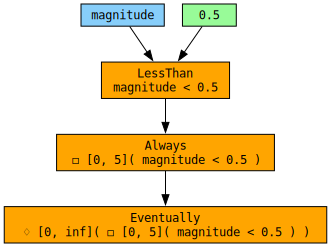

In [23]:
# nested temporal operators
# NOTE: temporal operatos pad signal with the value at the last time step
ϕ = Eventually(Always(distance_to_origin < 0.5, interval=[0, 5]))


ϕ(distance_to_origin);
make_stl_graph(ϕ)


### Until

In [30]:
ϕ = Until(avoid, reach, interval=None)

ϕ((distance_to_obstacle, distance_to_origin))

Array([0.01881605, 0.01881605, 0.01881605, 0.01881605, 0.01881605,
       0.01881605, 0.01881605, 0.01881605, 0.01881605, 0.01881605,
       0.01881605, 0.01881605, 0.01881605, 0.01881605, 0.01881605,
       0.01881605, 0.01889771, 0.02217305, 0.0412991 , 0.07640123,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067, 0.08110067, 0.08110067, 0.08110067,
       0.08110067, 0.08110067], dtype=float32)

### Multiple And (Or)

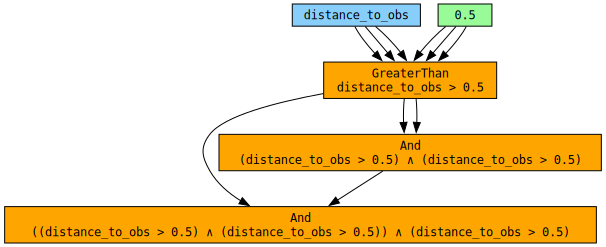

In [31]:
ψ = distance_to_obstacle > 0.5
ϕ = ψ & ψ & ψ  # equivalent to (ψ & ψ) & ψ  this formula is redundant, but just demonstrating functionality
ϕ(((distance_to_obstacle,distance_to_obstacle), distance_to_obstacle));
make_stl_graph(ϕ)

# similarly, you can do this with Or --> ψ | ψ | ψ


### Implies

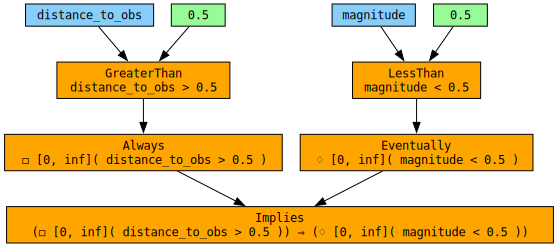

In [32]:
ϕ = Implies(avoid, reach)
ϕ((distance_to_obstacle,distance_to_obstacle));
make_stl_graph(ϕ)
